In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q tensorflow_hub

In [3]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

W0403 14:17:43.993769 139886424250240 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.13.1'

In [0]:
# need to add '/' before the path
data_root= '/content/drive/My Drive/maps'

In [49]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 400 images belonging to 4 classes.


In [50]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 4)


In [0]:
classifier_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/1"

In [0]:
def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

In [9]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 14:21:36.838158 139886424250240 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [53]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 400 images belonging to 4 classes.
Image batch shape:  (32, 299, 299, 3)
Labe batch shape:  (32, 4)


In [0]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

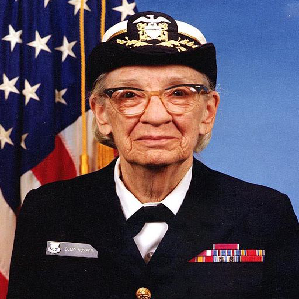

In [55]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

In [56]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(299, 299, 3)

In [57]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [58]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

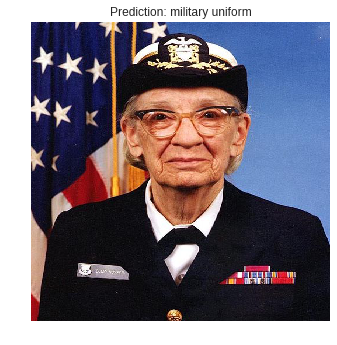

In [19]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

In [0]:
result_batch = classifier_model.predict(image_batch)

In [61]:
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['pick', 'jigsaw puzzle', 'envelope', 'jigsaw puzzle', 'web site',
       'jersey', 'shower cap', 'web site', 'envelope', 'envelope',
       'jigsaw puzzle', 'jigsaw puzzle', 'jigsaw puzzle', 'web site',
       'jigsaw puzzle', 'jigsaw puzzle', 'jellyfish', 'parachute',
       'jigsaw puzzle', 'envelope', 'jellyfish', 'web site',
       'jigsaw puzzle', 'jigsaw puzzle', 'envelope', 'sea slug',
       'web site', 'jigsaw puzzle', 'web site', 'jigsaw puzzle',
       'web site', 'goldfish'], dtype='<U30')

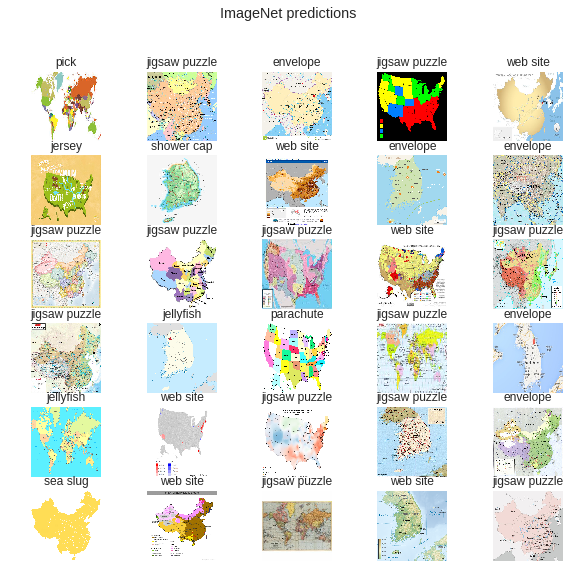

In [62]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Transfer Learning

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"

In [0]:
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

In [65]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 400 images belonging to 4 classes.
Image batch shape:  (32, 299, 299, 3)
Labe batch shape:  (32, 4)


In [0]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [0]:
features_extractor_layer.trainable = False

In [68]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 15:00:12.473241 139886424250240 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 8,196
Trainable params: 8,196
Non-trainable params: 0
_________________________________________________________________


In [0]:
init = tf.global_variables_initializer()
sess.run(init)

In [71]:
result = model.predict(image_batch)
result.shape

(32, 4)

In [0]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

In [79]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=20, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/20
12/12 [==============================] - 100s 8s/step - loss: 0.8868 - acc: 0.7310
Epoch 2/20
12/12 [==============================] - 91s 8s/step - loss: 0.7088 - acc: 0.8016
Epoch 3/20
12/12 [==============================] - 92s 8s/step - loss: 0.5333 - acc: 0.8886
Epoch 4/20
12/12 [==============================] - 92s 8s/step - loss: 0.4921 - acc: 0.8560
Epoch 5/20
12/12 [==============================] - 92s 8s/step - loss: 0.4022 - acc: 0.9239
Epoch 6/20
12/12 [==============================] - 91s 8s/step - loss: 0.3599 - acc: 0.9266
Epoch 7/20
12/12 [==============================] - 92s 8s/step - loss: 0.3320 - acc: 0.9375
Epoch 8/20
12/12 [==============================] - 92s 8s/step - loss: 0.2893 - acc: 0.9592
Epoch 9/20
12/12 [==============================] - 91s 8s/step - loss: 0.2517 - acc: 0.9674
Epoch 10/20
12/12 [==============================] - 92s 8s/step - loss: 0.2420 - acc: 0.9701
Epoch 11/20
12/12 [==============================] - 91s 8s/step - l

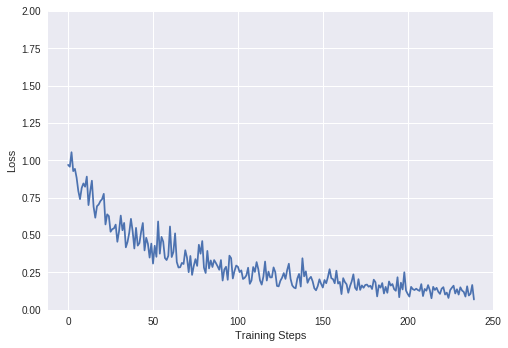

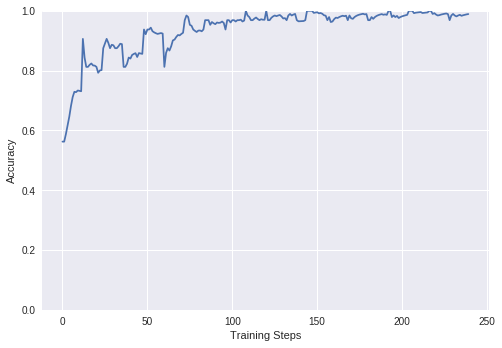

In [80]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

In [81]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['China', 'South_Korea', 'United_States', 'World'], dtype='<U13')

In [82]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['South_Korea', 'China', 'World', 'United_States', 'World', 'World',
       'World', 'World', 'South_Korea', 'United_States', 'World', 'China',
       'South_Korea', 'United_States', 'South_Korea', 'China', 'World',
       'South_Korea', 'China', 'South_Korea', 'China', 'World', 'World',
       'South_Korea', 'United_States', 'United_States', 'United_States',
       'World', 'United_States', 'South_Korea', 'World', 'World'],
      dtype='<U13')

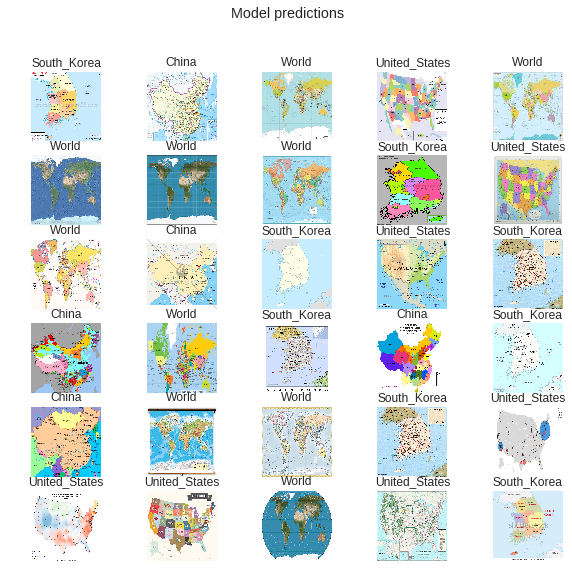

In [83]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [84]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


W0403 15:40:02.895960 139886424250240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:1436: update_checkpoint_state (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 15:40:09.584309 139886424250240 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W0403 15:40:12.932308 139886424250240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:257: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0403 15:40:12.935137 139886424250240 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0403 15:40:12.938966 139886424250240 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0403 15:40:12.942090 139886424250240 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


I0403 15:40:12.945338 139886424250240 export.py:587] Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0403 15:40:12.947763 139886424250240 export.py:587] Signatures INCLUDED in export for Eval: None


W0403 15:40:12.950609 139886424250240 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0403 15:40:14.045864 139886424250240 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0403 15:40:14.050813 139886424250240 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 15:40:19.198090 139886424250240 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0403 15:40:21.345410 139886424250240 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0403 15:40:21.347656 139886424250240 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0403 15:40:21.360417 139886424250240 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0403 15:40:21.363397 139886424250240 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


I0403 15:40:21.367500 139886424250240 export.py:587] Signatures INCLUDED in export for Eval: ['eval']


W0403 15:40:21.370406 139886424250240 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0403 15:40:22.391407 139886424250240 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0403 15:40:22.393675 139886424250240 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0403 15:40:29.087589 139886424250240 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0403 15:40:31.149614 139886424250240 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0403 15:40:31.151873 139886424250240 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0403 15:40:31.160959 139886424250240 export.py:587] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0403 15:40:31.165837 139886424250240 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0403 15:40:31.170820 139886424250240 export.py:587] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:No assets to save.


I0403 15:40:32.194604 139886424250240 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0403 15:40:32.197098 139886424250240 builder_impl.py:124] No assets to write.


INFO:tensorflow:SavedModel written to: ./saved_models/1554305990/saved_model.pb


I0403 15:40:33.098200 139886424250240 builder_impl.py:414] SavedModel written to: ./saved_models/1554305990/saved_model.pb


b'./saved_models/1554305990'